In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from nltk.tokenize import sent_tokenize
import time
import torch
import spacy
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/qujianning/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [56]:
# prepare text using the both the nltk sentence tokenizer (https://www.nltk.org/api/nltk.tokenize.html)
# AND the spacy english pipeline (see https://spacy.io/models/en)


def prepare_texts(text, min_frequency=3):
    
    # Get a callable object from spacy that processes the text - lemmatizes and determines part of speech

    nlp = spacy.load("en_core_web_sm")
    
    # Some text cleaning. Do it by sentence, and eliminate punctuation.
    lemmas = []
    for sent in sent_tokenize(text):  # sent_tokenize separates the sentences 
        for tok in nlp(sent):         # nlp processes as in Part III
            if tok.pos_ not in ["PUNCT", "SPACE", "SYM", "NUM", "X"] and tok.lemma_ not in "[]|.,/?'\"+-=":
                lemmas.append(tok.lemma_)
    
    # Count the frequency of each lemmatized word
    freqs = Counter()  # word -> occurrence
    for w in lemmas:
        freqs[w] += 1
        
    vocab = list(freqs.items())  # List of (word, occurrence)
    vocab = sorted(vocab, key=lambda item: item[1], reverse=True)  # Sort by decreasing frequency
    
    # per Mikolov, don't use the infrequent words, as there isn't much to learn in that case
    
    frequent_vocab = list(filter(lambda item: item[1]>=min_frequency, vocab))
    
    # Create the dictionaries to go from word to index or vice-verse
    
    w2i = {w[0]:i for i,w in enumerate(frequent_vocab)}
    i2w = {i:w[0] for i,w in enumerate(frequent_vocab)}
    
    # Create an Out Of Vocabulary (oov) token as well
    w2i["<oov>"] = len(frequent_vocab)
    i2w[len(frequent_vocab)] = "<oov>"
    
    # Set all of the words not included in vocabulary nuas oov
    filtered_lemmas = []
    for lem in lemmas:
        if lem not in w2i:
            filtered_lemmas.append("<oov>")
        else:
            filtered_lemmas.append(lem)
    
    return filtered_lemmas, w2i, i2w

In [57]:
# 1. Reading the text file
with open("LargerCorpus.txt", 'r') as file:
    text = file.read()

# 2. Processing the content using prepare_texts
filtered_lemmas, w2i, i2w = prepare_texts(text)

# 3. Determine number of words and vocabulary size
num_words = len(filtered_lemmas)
vocab_size = len(w2i)

print(f"Number of words in the text: {num_words}")
print(f"Size of the filtered vocabulary: {vocab_size}")

# 4. Extracting top 20 most frequent words
frequent_words = list(w2i.keys())[:20]  # Assuming w2i is already ordered by frequency
print("\nTop 20 most frequent words:")
print(frequent_words)
 

Number of words in the text: 62255
Size of the filtered vocabulary: 2569

Top 20 most frequent words:
['the', 'of', 'be', 'and', 'in', 'to', 'a', 'for', 'as', 'by', 'he', 'with', 'coin', 'this', 'on', 'his', 'which', 'at', 'it', 'from']


### tokenize_and_preprocess_text creates the training samples for the model. It walks through each word in the corpus, and looks at a window (of size 'window') of words and creates input/output prediction pairs.  We need both positive (in window) samples and negative (out of window) samples.

In [58]:
import random

def tokenize_and_preprocess_text(textlist, w2i, window):
    """
    Skip-gram negative sampling: Predict if the target word is in the context.
    Uses binary prediction so we need both positive and negative samples
    """
    X, T, Y = [], [], []

    # 1. Tokenize the input
    tokenized_text = [w2i[word] if word in w2i else w2i["<oov>"] for word in textlist]
    
    # 2. Loop through each token
    for idx, token in enumerate(tokenized_text):
        # Positive samples
        start = max(0, idx - window + 1)
        end = min(len(tokenized_text), idx + window)
        
        for j in range(start, end):
            if j != idx:  # Make sure not to include the word itself
                X.append(token)
                T.append(tokenized_text[j])
                Y.append(1)  # Positive sample
        
        # Negative samples
        for _ in range(end - start - 1):  # Minus one to exclude the word itself
            random_token = random.choice(tokenized_text)
            while random_token == token:  # Ensure random word is different from the current word
                random_token = random.choice(tokenized_text)
            X.append(token)
            T.append(random_token)
            Y.append(-1)  # Negative sample

    print(f"Total number of examples (both positive and negative): {len(X)}")
    return X, T, Y

# Define window size
window_size = 5

# 2. Generate Training Samples
X, T, Y = tokenize_and_preprocess_text(filtered_lemmas, w2i, window_size)

# 3. Examine the results
print("First 10 target tokens:", X[:10])
print("First 10 context tokens:", T[:10])
print("First 10 labels (1 for positive, -1 for negative):", Y[:10])

# Check total number of examples
print(f"Total number of examples: {len(X)}")



Total number of examples (both positive and negative): 996040
First 10 target tokens: [706, 706, 706, 706, 706, 706, 706, 706, 82, 82]
First 10 context tokens: [82, 1, 0, 2568, 0, 972, 7, 30, 706, 1]
First 10 labels (1 for positive, -1 for negative): [1, 1, 1, 1, -1, -1, -1, -1, 1, 1]
Total number of examples: 996040


In [59]:
from math import sqrt


def subsample_probability(frequency, t=1e-5):
    return min(1, (sqrt(frequency / t) + 1) * (t / frequency))

def tokenize_and_preprocess_text_subsample(textlist, w2i, window):
    """
    Skip-gram negative sampling with subsampling of frequent words.
    """
    X, T, Y = [], [], []

    # Calculate total word count for frequencies
    total_count = len(textlist)
    word_frequencies = {word: count / total_count for word, count in Counter(textlist).items()}
    
    # Tokenized and subsampled text
    subsampled_text = [word for word in textlist if random.random() < subsample_probability(word_frequencies[word])]

    # 2. Loop through each token
    for idx, token in enumerate(subsampled_text):
        # Positive samples
        start = max(0, idx - window + 1)
        end = min(len(subsampled_text), idx + window)
        
        for j in range(start, end):
            if j != idx:  # Make sure not to include the word itself
                X.append(token)
                T.append(subsampled_text[j])
                Y.append(1)  # Positive sample
        
        # Negative samples
        for _ in range(end - start - 1):  # Minus one to exclude the word itself
            random_token = random.choice(subsampled_text)
            while random_token == token:  # Ensure random word is different from the current word
                random_token = random.choice(subsampled_text)
            X.append(token)
            T.append(random_token)
            Y.append(-1)  # Negative sample

    print(f"Total number of examples (both positive and negative): {len(X)}")
    return X, T, Y

# Usage
X, T, Y = tokenize_and_preprocess_text_subsample(filtered_lemmas, w2i, 5)

# Check total number of examples
print(f"Total number of examples after subsampling: {len(X)}")


Total number of examples (both positive and negative): 133352
Total number of examples after subsampling: 133352


## Define Model that will be trained to produce word vectors

In [60]:
class SkipGramNegativeSampling(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        
        # Initialize the embedding layer with `vocab_size` and `embedding_size`
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        
    def forward(self, x, t):
        # x: torch.tensor of shape (batch_size), context word
        # t: torch.tensor of shape (batch_size), target ("output") word.
        
        # Fetch the embeddings for the context and target words
        x_embed = self.embedding(x)
        t_embed = self.embedding(t)
        
        # Compute the dot product for each pair of context and target embeddings
        prediction = torch.sum(x_embed * t_embed, dim=1)
        
        return prediction


#### The training function - give it the text and it does the rest

Total number of examples (both positive and negative): 996040
Epoch 1/30, Training Loss: 0.8585, Validation Loss: 0.7649
Epoch 2/30, Training Loss: 0.7223, Validation Loss: 0.7259
Epoch 3/30, Training Loss: 0.6776, Validation Loss: 0.7089
Epoch 4/30, Training Loss: 0.6467, Validation Loss: 0.7007
Epoch 5/30, Training Loss: 0.6232, Validation Loss: 0.7007
Epoch 6/30, Training Loss: 0.6043, Validation Loss: 0.7007
Epoch 7/30, Training Loss: 0.5865, Validation Loss: 0.7023
Epoch 8/30, Training Loss: 0.5710, Validation Loss: 0.7053
Epoch 9/30, Training Loss: 0.5555, Validation Loss: 0.7070
Epoch 10/30, Training Loss: 0.5385, Validation Loss: 0.7045
Epoch 11/30, Training Loss: 0.5201, Validation Loss: 0.7016
Epoch 12/30, Training Loss: 0.5034, Validation Loss: 0.6969
Epoch 13/30, Training Loss: 0.4885, Validation Loss: 0.6958
Epoch 14/30, Training Loss: 0.4751, Validation Loss: 0.6976
Epoch 15/30, Training Loss: 0.4673, Validation Loss: 0.6990
Epoch 16/30, Training Loss: 0.4599, Validation 

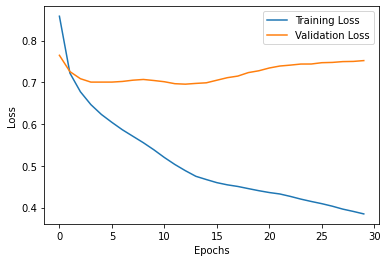

In [63]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train_sgns(textlist, window=5, embedding_size=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. Create Training Data
    X, T, Y = tokenize_and_preprocess_text(textlist, w2i, window)
    X = torch.tensor(X, dtype=torch.long)
    T = torch.tensor(T, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.float32)
    
    # 2. Split the training data: 80% for training and 20% for validation
    dataset = TensorDataset(X, T, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # 3. Initialize the model and optimizer
    network = SkipGramNegativeSampling(vocab_size=len(w2i), embedding_size=embedding_size).to(device)
    optimizer = torch.optim.Adam(network.parameters(), lr=4e-4)  
    
    epochs = 30
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        network.train()
        total_loss = 0
        for x_batch, t_batch, y_batch in train_loader:
            x_batch, t_batch, y_batch = x_batch.to(device), t_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            prediction = network(x_batch, t_batch)
            
            # Custom loss function
            loss = -torch.mean(y_batch * torch.log(torch.sigmoid(prediction) + 1e-5) + 
                              (1 - y_batch) * torch.log(1 - torch.sigmoid(prediction) + 1e-5))
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        train_losses.append(total_loss / len(train_loader))
        
        # Validation loss
        network.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, t_batch, y_batch in val_loader:
                prediction = network(x_batch, t_batch)
                loss = -torch.mean(y_batch * torch.log(torch.sigmoid(prediction) + 1e-5) + 
                                  (1 - y_batch) * torch.log(1 - torch.sigmoid(prediction) + 1e-5))
                total_val_loss += loss.item()
                
        val_losses.append(total_val_loss / len(val_loader))
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plotting the training and validation curves
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return network

# Run the training loop
network = train_sgns(filtered_lemmas)

### Run Training and retrieve embedding

In [50]:
# Run the training loop
network = train_sgns(filtered_lemmas)

### Reduce the Dimensionality of Embeddings and Display

Visualizing the 20 to 80 most frequent words


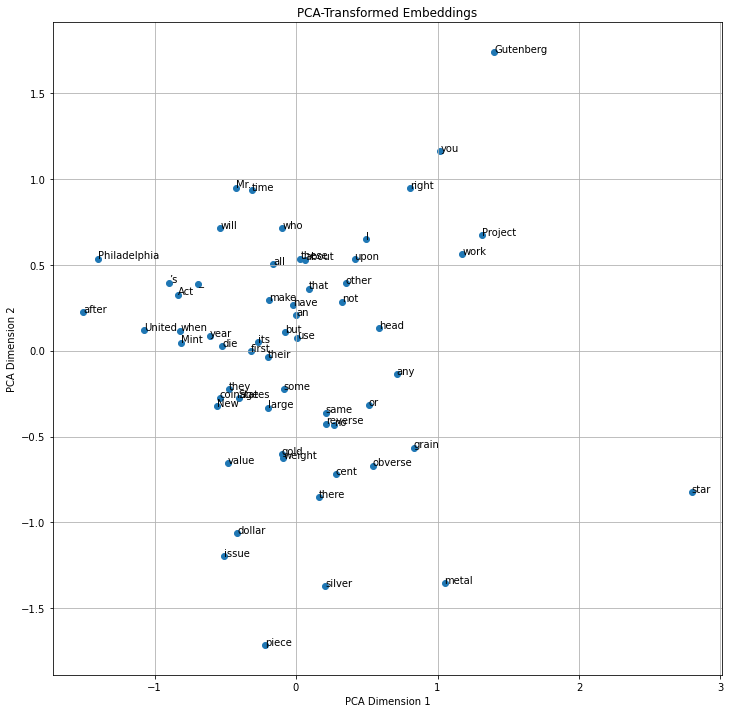

In [68]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

def visualize_embedding(embedding, most_frequent_from=20, most_frequent_to=80):
    print ("Visualizing the {} to {} most frequent words".format(most_frequent_from, most_frequent_to))
    
    # since the embeddings are ordered from most frequent words to least frequent, 
    # we can easily select a sub range of the most frequent words:
    
    selected_words = embedding[most_frequent_from:most_frequent_to, :]
    
    # The function below will reduce a vector to 2 principle components
    
    pca = PCA(n_components=2)
    
    # Transform the selected embeddings to have 2 dimensions
    
    embeddings_2d = pca.fit_transform(selected_words)
    
    # Plot the the reduced embeddings - a point and the word itself
    
    plt.figure(figsize=(12, 12))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, word in enumerate(list(i2w.values())[most_frequent_from:most_frequent_to]):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
        
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.title('PCA-Transformed Embeddings')
    plt.grid(True)
    plt.show()
    
embeddings_tensor = network.embedding.weight.data
visualize_embedding(embeddings_tensor.cpu().detach().numpy(), most_frequent_from=20, most_frequent_to=80)
